## Select seed

In [4]:
import sys
my_seed = 0 # int(sys.argv[1])

## Filenames to save results in npy format per method

In [5]:
filename_grr = 'results/adults/GRR_'

## Numba and Ray libraries for speeding up things

In [6]:
from numba import jit
!pip install ray
import ray

## GRR function

In [7]:
@jit(nopython=True)
def GRR(x, lst_val, p, q):
    """
    GRR mechanism
    input: true value x, domain values 'lst_val', and probabilities p,q
    output: true value w.p. 'p', random value (except x) w.p. 'q'
    """
    
    rnd = np.random.random()

    if rnd <=p:    
        return x
    else:
        return np.random.choice(lst_val[lst_val !=x]) 

## Main libraries

In [8]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd; pd.set_option('mode.chained_assignment',None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
import copy

import time
import csv
from pandas.core.common import flatten

#config for plots
import matplotlib
params = {'axes.titlesize':'16',
          'xtick.labelsize':'16',
          'ytick.labelsize':'16',
          'font.size':'16',
          'legend.fontsize':'medium',
          'lines.linewidth':'2',
          'font.weight':'normal',
          'lines.markersize':'10'
          }
matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Reading dataset

In [9]:
df = pd.read_csv('C:\\Users\\phdwf\\Documents\\risks--mdp\\datasets\\db_Adult.csv')# df = df.sample(frac=0.1) 
# df.reset_index(inplace=True, drop=True)
df.reset_index(inplace=True)
df.rename(columns={'index': 'ID', 'marital-status': 'marital_status', 'native-country': 'native_country'}, inplace=True)
df

,ID,age,workclass,education,marital_status,occupation,relationship,race,sex,native_country,salary
0,0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...
45217,45217,33,Private,Bachelors,Never-married,Prof-specialty,Own-child,White,Male,United-States,<=50K
45218,45218,39,Private,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,United-States,<=50K
45219,45219,38,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
45220,45220,44,Private,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,United-States,<=50K


## Dataset to work with

In [10]:
attributes = list(df.drop('ID', axis=1).columns)

LE = LabelEncoder()

for col in attributes:
    df[col] = LE.fit_transform(df[col])
df

,ID,age,workclass,education,marital_status,occupation,relationship,race,sex,native_country,salary
0,0,22,5,9,4,0,1,4,1,38,0
1,1,33,4,9,2,3,0,4,1,38,0
2,2,21,2,11,0,5,1,4,1,38,0
3,3,36,2,1,2,5,0,2,1,38,0
4,4,11,2,9,2,9,5,2,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...
45217,45217,16,2,9,4,9,3,4,1,38,0
45218,45218,22,2,9,0,9,1,4,0,38,0
45219,45219,21,2,9,2,9,0,4,1,38,0
45220,45220,27,2,9,0,0,3,1,1,38,0


## Static parameters for $\epsilon$-LDP

In [11]:
nb_seed = 1

#number of users (n)
n = df.shape[0]
print('Number of Users =',n)

#number of dimensions (d)
d = len(attributes)
print('Number of Attributes =', d)

#domain size of attributse
lst_k = [len(df[att].unique()) for att in attributes]
print('Domain size of attributes =', lst_k)

#number of surveys (nb_surveys)
nb_surveys = 5
print('Number of Surveys =', nb_surveys)

#min number of attributes per survey
min_att_per_survey = np.rint(d/2).astype(int)
print('Min number of attributes per survey =', min_att_per_survey)

#range of epsilon
lst_eps = list(range(1, 11))
print('Epsilon values =', lst_eps)

Number of Users = 45222
Number of Attributes = 10
Domain size of attributes = [74, 7, 16, 7, 14, 6, 5, 2, 41, 2]
Number of Surveys = 5
Min number of attributes per survey = 5
Epsilon values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


## Re-identification Attack Function

In [12]:
import numpy as np
import pandas as pd
import os

@ray.remote
def attack_re_identification(lst_idx, dic_id, df):
    lst_topk = []
    
    # 预处理 df，一次性填充缺失值并转换为 int，然后转换为 numpy 数组
    df_clean = df.fillna(-1).astype(int)
    arr_df = df_clean.to_numpy()  # shape: (n, d)
    df_index = df_clean.index    # 保留原始的行索引
    
    for i, usr_id in enumerate(lst_idx):
        if i % 100 == 0:
            print(f"(attack_re_identification pid={os.getpid()}) Processing user {i}/{len(lst_idx)}")
        
        # 生成新行：和原来的逻辑一致
        new_row = pd.DataFrame.from_dict(dic_id[usr_id], orient='index').transpose()
        # 关键步骤：重排 new_row 的列以匹配 df_clean 的列顺序
        new_row = new_row.reindex(columns=df_clean.columns)
        new_row = new_row.fillna(-1).astype(int)
        # 转换为一维数组
        arr_new = new_row.to_numpy()[0]
        
        # 计算新行与 arr_df 中每一行的相似度（直接比较对应元素是否相等，并沿 axis=1 求和）
        similarity = np.sum(arr_df == arr_new, axis=1)
        
        # 构造辅助 DataFrame 用于后续的排序和抽样（保持原逻辑不变）
        df_similarity = pd.DataFrame({'Similarity': similarity}, index=df_index)
        df_similarity = df_similarity.sort_values('Similarity', ascending=False)
        
        # 抽取与最高相似度相同的索引
        max_sim = df_similarity['Similarity'].max()
        lst_ids = list(df_similarity.loc[df_similarity['Similarity'] == max_sim].sample(frac=1).index)
        
        # 如果不足 10 个，依次补充相似度次高的行
        for simi in range(1, 5): 
            if len(lst_ids) >= 10:
                break
            additional = list(df_similarity.loc[df_similarity['Similarity'] == max_sim - simi].sample(frac=1).index)
            lst_ids += additional
        
        # 保持原有逻辑：查找 usr_id 在前 10 个中的位置
        top10_ids = np.array(lst_ids)[:10]
        matching = np.where(usr_id == top10_ids)[0]
        if matching.size > 0:
            lst_topk.append(matching[0] + 1)
        else:
            print(f"(attack_re_identification pid={os.getpid()}) Warning: user {usr_id} not found in top 10")
            lst_topk.append(11)
                
    return lst_topk



## Reidentification Smp[GRR]: No Knowledge, Surveys with Different Attributes, Uniform $\epsilon$

In [ ]:
starttime = time.time()

ray.shutdown()

nb_cores = 12
ray.init(num_cpus=nb_cores, log_to_driver=False)

#run experiments 'nb_seed' times
#for seed in range(nb_seed):
print(my_seed)

np.random.seed(my_seed) 

# initialize dictionary to save number of people re-identified per epsilon
re_ident_attack = {} 

# divide the dataset in nb_cores equal parts for later parallelization with Ray library
lst_idx_per_core = [list(_) for _ in np.array_split(df.index, nb_cores)]

# Randomly choose the number of attributes for each survey between min_att_per_survey and d
nb_att_survey = np.random.randint(min_att_per_survey, d, nb_surveys)

# Randomly select the indexes of the attributes for each survey
lst_att_survey = [np.random.choice(range(d), nb, replace=False) for nb in nb_att_survey]

#for each epsilon
for eps_l in lst_eps: 

    #Initializing a dictionary for each users' profile
    dic_id = {ID:{att:[] for att in attributes} for ID in range(n)}

    #Dictionary to save number of re-identified profiles per top-k group
    atk_top_k = {survey:{top_k:0 for top_k in range(1, 11)} for survey in range(1, nb_surveys + 1)}

    #For each survey
    for survey in range(1, nb_surveys + 1):  

        # we'll shuffle the users' order in the dataset
        df_shfl = df.sample(frac=1, random_state=my_seed+survey) #change seed with survey
        df_shfl.reset_index(drop=True, inplace=True)

        # we'll partitionate the users indexes to separate in nb_att_survey groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(df_shfl.index, nb_att_survey[survey - 1])]

        idx=0 #index for attribute
        for index_att in lst_att_survey[survey - 1]: #for each attribute of the survey

            att = attributes[index_att] #select attribute

            k = lst_k[index_att] #domain size of attribute

            lst_val = np.arange(k) #range of attribute

            # GRR parameters 
            p = np.exp(eps_l) / (np.exp(eps_l) + k - 1) 
            q = (1 - p) / (k - 1)

            # select users that report this attribute
            for ind, row in df_shfl.iloc[lst_index[idx]].iterrows():

                #confirm the user has never reported this attribute
                if len(dic_id[row['ID']][att]) == 0:
                    dic_id[row['ID']][att].append(GRR(row[att], lst_val, p, q))

                #select another non-reported attribute for the user
                else:
                    #select at random a non-reported attribute
                    add_att = np.random.choice(np.where(np.array([len(dic_id[row['ID']][att]) for att in attributes])==0)[0])

                    new_att = attributes[add_att] #select the new attribute

                    new_k = lst_k[add_att] #domain size of new attribute

                    new_lst_val = np.arange(new_k) #range of new attribute

                    # new GRR parameters 
                    new_p = np.exp(eps_l) / (np.exp(eps_l) + new_k - 1) 
                    new_q = (1 - new_p) / (new_k - 1)

                    dic_id[row['ID']][new_att].append(GRR(row[new_att], new_lst_val, new_p, new_q))
            idx+=1

        #start attacking after 2 surveys
        if survey >= 2:

            result_parallel = [] #initialize list for parallelized results
            for lst_idx in lst_idx_per_core: 

                result_parallel.append(attack_re_identification.remote(lst_idx, dic_id, df)) #use remote function from Ray library

            parallel_atk = list(flatten(ray.get(result_parallel))) #take results with get function from Ray library

            lst_top_k = np.zeros(11) #initialize list of top-k re-identification attack

            for idx in range(len(parallel_atk)): #for each attacked profile

                for top_k in range(parallel_atk[idx], 11): #count as attack the top-k's group
                    lst_top_k[top_k] += 1

            atk_top_k[survey] = lst_top_k #store attack result for this number of surveys

    #for each epsilon we save the number of re-identified profiles for all top-k
    re_ident_attack[eps_l] = atk_top_k

# Saving to local file
import os

# 确保目录存在
output_dir = 'results/adults'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 保存到本地文件
np.save(os.path.join(output_dir, 'GRR_Smp_Re_Ident_Attack_LDP_FK_Uniform_Seed_'+str(my_seed)+'.npy'), re_ident_attack) 
print('That took {} seconds'.format(time.time() - starttime))  

2025-03-08 15:42:42,489	INFO worker.py:1841 -- Started a local Ray instance.


0
That took 1456.9911515712738 seconds


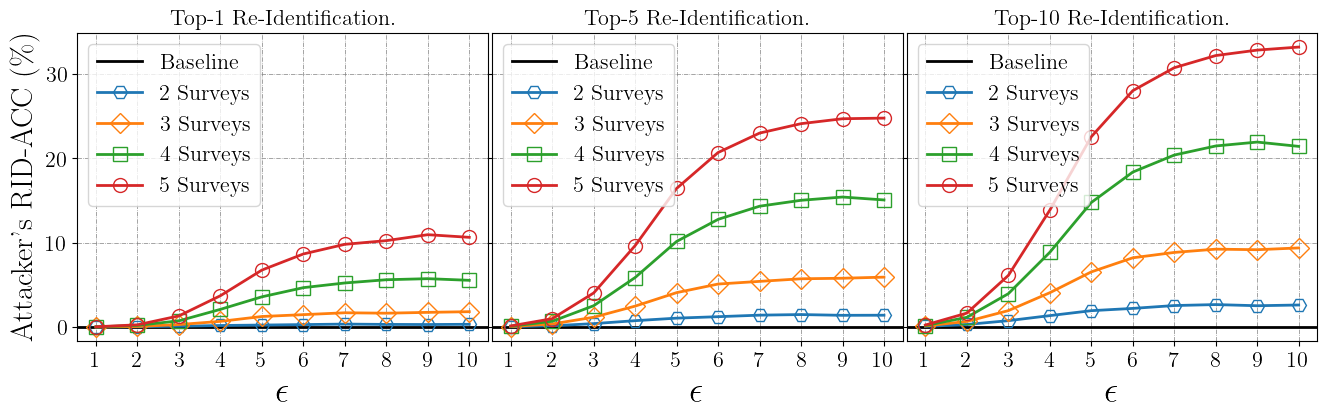

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
plt.subplots_adjust(wspace=0.01)

r = 0 #row

markers = ['H', 'D', 's', 'o'] 
lines = ['dashed', 'dotted', 'dashdot', (0, (1, 10))]

for top_k in [1, 5, 10]:
    ax[r].grid(color='grey', linestyle='dashdot', linewidth=0.5)
    ax[r].axhline(y= 100 * top_k/n, color='black', label='Baseline') #our baseline is a random top-k group
    
    #averaging results over nb_seed times
    for survey in range(2, nb_surveys + 1):
        
        lst_resul_atk = []
        for seed in range(nb_seed):
            lst_resul_atk.append(np.load(filename_grr+'Smp_Re_Ident_Attack_LDP_FK_Uniform_Seed_'+str(seed)+'.npy', allow_pickle=True).reshape(-1))
        
        error_rate_atk = 100 * np.array([np.mean([lst_resul_atk[idx][0][eps_l][survey][top_k] for idx in range(nb_seed)]).astype(int) for eps_l in lst_eps])/n
        
        ax[r].plot(range(len(lst_eps)), error_rate_atk, label=str(survey)+' Surveys', marker=markers[survey-2], markerfacecolor='none')

    ax[r].set_title('Top-'+ str(top_k)+ ' Re-Identification.')
    ax[r].set_xlabel('$\epsilon$', fontsize=26)
    ax[0].set_ylabel("Attacker's RID-ACC (\%)", fontsize=22)
    ax[r].set_xticks(range(len(lst_eps)))
    ax[r].set_xticklabels(lst_eps)
#     ax[r].set_ylim(-1, 35)
    ax[r].legend(loc='upper left')
    
    r += 1 
    
# plt.savefig(, dpi=500, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

## Reidentification Smp[GRR]: No Knowledge, Non-Uniform $\epsilon$

In [15]:
starttime = time.time()

ray.shutdown()

nb_cores = 12
ray.init(num_cpus=nb_cores, log_to_driver=False)

#run experiments 'nb_seed' times
# for seed in range(nb_seed):
print(my_seed)

np.random.seed(my_seed) 

# initialize dictionary to save number of people re-identified per epsilon
re_ident_attack = {} 

# divide the dataset in nb_cores equal parts for later parallelization with Ray library
lst_idx_per_core = [list(_) for _ in np.array_split(df.index, nb_cores)]

# Randomly choose the number of attributes for each survey between min_att_per_survey and d
nb_att_survey = np.random.randint(min_att_per_survey, d, nb_surveys)

# Randomly select the indexes of the attributes for each survey
lst_att_survey = [np.random.choice(range(d), nb, replace=False) for nb in nb_att_survey]

#for each epsilon
for eps_l in lst_eps: 

    #Initializing a dictionary for each users' profile
    dic_id = {ID:{att:[] for att in attributes} for ID in range(n)}

    #Dictionary to save number of re-identified profiles per top-k group
    atk_top_k = {survey:{top_k:0 for top_k in range(1, 11)} for survey in range(1, nb_surveys + 1)}

    #For each survey
    for survey in range(1, nb_surveys + 1):  

        # we'll shuffle the users' order in the dataset
        df_shfl = df.sample(frac=1, random_state=my_seed+survey) #change seed with survey
        df_shfl.reset_index(drop=True, inplace=True)

        # we'll partitionate the users indexes to separate in nb_att_survey groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(df_shfl.index, nb_att_survey[survey - 1])]

        idx=0 #index for attribute
        for index_att in lst_att_survey[survey - 1]: #for each attribute of the survey

            att = attributes[index_att] #select attribute

            k = lst_k[index_att] #domain size of attribute

            lst_val = np.arange(k) #range of attribute

            # GRR parameters 
            p = np.exp(eps_l) / (np.exp(eps_l) + k - 1) 
            q = (1 - p) / (k - 1)

            # select users that report this attribute
            for ind, row in df_shfl.iloc[lst_index[idx]].iterrows():

                #confirm the user has never reported this attribute
                if len(dic_id[row['ID']][att]) == 0:
                    dic_id[row['ID']][att].append(GRR(row[att], lst_val, p, q))

            idx+=1

        #start attacking after 2 surveys
        if survey >= 2:

            result_parallel = [] #initialize list for parallelized results
            for lst_idx in lst_idx_per_core: 

                result_parallel.append(attack_re_identification.remote(lst_idx, dic_id, df)) #use remote function from Ray library

            parallel_atk = list(flatten(ray.get(result_parallel))) #take results with get function from Ray library

            lst_top_k = np.zeros(11) #initialize list of top-k re-identification attack

            for idx in range(len(parallel_atk)): #for each attacked profile

                for top_k in range(parallel_atk[idx], 11): #count as attack the top-k's group
                    lst_top_k[top_k] += 1

            atk_top_k[survey] = lst_top_k #store attack result for this number of surveys

    #for each epsilon we save the number of re-identified profiles for all top-k
    re_ident_attack[eps_l] = atk_top_k

# Saving to local file
np.save(filename_grr+'Smp_Re_Ident_Attack_LDP_FK_NonUniform_Seed_'+str(my_seed)+'.npy', re_ident_attack) 
    
print('That took {} seconds'.format(time.time() - starttime))    

2025-03-08 16:07:02,285	INFO worker.py:1841 -- Started a local Ray instance.


0


KeyboardInterrupt: 

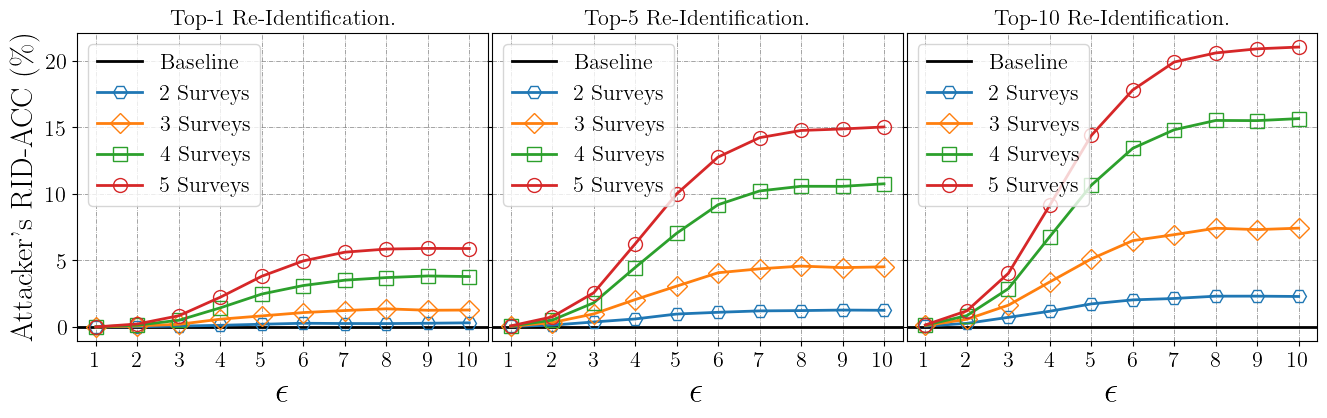

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
plt.subplots_adjust(wspace=0.01)

r = 0 #row

markers = ['H', 'D', 's', 'o'] 
lines = ['dashed', 'dotted', 'dashdot', (0, (1, 10))]

for top_k in [1, 5, 10]:
    ax[r].grid(color='grey', linestyle='dashdot', linewidth=0.5)
    ax[r].axhline(y= 100 * top_k/n, color='black', label='Baseline') #our baseline is a random top-k group
    
    #averaging results over nb_seed times
    for survey in range(2, nb_surveys + 1):
        
        lst_resul_atk = []
        for seed in range(nb_seed):
            lst_resul_atk.append(np.load(filename_grr+'Smp_Re_Ident_Attack_LDP_FK_NonUniform_Seed_'+str(seed)+'.npy', allow_pickle=True).reshape(-1))
        
        error_rate_atk = 100 * np.array([np.mean([lst_resul_atk[idx][0][eps_l][survey][top_k] for idx in range(nb_seed)]).astype(int) for eps_l in lst_eps])/n
        
        ax[r].plot(range(len(lst_eps)), error_rate_atk, label=str(survey)+' Surveys', marker=markers[survey-2], markerfacecolor='none')

    ax[r].set_title('Top-'+ str(top_k)+ ' Re-Identification.')
    ax[r].set_xlabel('$\epsilon$', fontsize=26)
    ax[0].set_ylabel("Attacker's RID-ACC (\%)", fontsize=22)
    ax[r].set_xticks(range(len(lst_eps)))
    ax[r].set_xticklabels(lst_eps)
#     ax[r].set_ylim(-1, 35)
    ax[r].legend(loc='upper left')
    
    r += 1 
    
# plt.savefig(, dpi=500, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

## Static parameters for $\alpha$-PIE

In [ ]:
#number of users (n)
n = df.shape[0]
print('Number of Users =',n)

#number of dimensions (d)
d = len(attributes)
print('Number of Attributes =', d)

#domain size of attributse
lst_k = [len(df[att].unique()) for att in attributes]
print('Domain size of attributes =', lst_k)

#number of surveys (nb_surveys)
nb_surveys = 5
print('Number of Surveys =', nb_surveys)

#min number of attributes per survey
min_att_per_survey = np.rint(d/2).astype(int)
print('Min number of attributes per survey =', min_att_per_survey)

#The minimum number of users reporting each attribute to ensure a set size |U|
n_d = int(n/min_att_per_survey)
print('Min number of users per attribute =', n_d)

#range of bayes_error 
lst_bayes_error = [round(val, 2) for val in np.arange(0.5, 1, 0.05)[::-1]]
print('Bayes Error values =', lst_bayes_error)

Number of Users = 45222
Number of Attributes = 10
Domain size of attributes = [74, 7, 16, 7, 14, 6, 5, 2, 41, 2]
Number of Surveys = 5
Min number of attributes per survey = 5
Min number of users per attribute = 9044
Bayes Error values = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5]


In [ ]:
def get_eps_from_bayes_error(bayes_error, n, k):

    min_term = min(np.log2(n), np.log2(k)) #from Eq.(16) of PIA privacy paper [1] from Murakami & Takahashi (2021).

    alpha = - ((bayes_error - 1) * np.log2(n) - 1) #from Eq.(12) of PIA privacy paper [1] from Murakami & Takahashi (2021).

    eq = ((k-1)*alpha + min_term)/(min_term - alpha) #from Eq.() of our paper

    if eq < 0: #from Prop. 9 of PIA privacy paper [1] from Murakami & Takahashi (2021).
        #Proposition 9 states that we do not need to use LDP when the I(U;X) is small (i.e., for small domain sizes k). 

        return 0 #the 0 value will represent that no budget was consumed
        
    else:
        #if domain size is large, an LDP mechanism is required.

        return np.log(eq) #from Eq.() of our paper

In [ ]:
def generic_get_eps_from_bayes_error(bayes_error, n, k):

    min_term = min(np.log2(n), np.log2(k)) #from Eq.(16) of PIA privacy paper [1] from Murakami & Takahashi (2021).

    alpha = - ((bayes_error - 1) * np.log2(n) - 1) #from Eq.(12) of PIA privacy paper [1] from Murakami & Takahashi (2021).

    eps = alpha/np.log2(np.e) #from Eq.(14) of PIA privacy paper [1] from Murakami & Takahashi (2021).
    
    if eps * np.log2(np.e) > min_term: 

        return 0 #the 0 value will represent that no budget was consumed
        
    else:
        
        return eps #from Eq.() of our paper

## Reidentification Smp[GRR]: No Knowledge, Surveys with Different Attributes, Uniform $\alpha$

In [ ]:
starttime = time.time()

ray.shutdown()

nb_cores = 12
ray.init(num_cpus=nb_cores, log_to_driver=False)

#run experiments 'nb_seed' times
# for seed in range(nb_seed):
print(my_seed)

np.random.seed(my_seed) 

# initialize dictionary to save number of people re-identified per epsilon
re_ident_attack_pie = {} 

# divide the dataset in nb_cores equal parts for later parallelization with Ray library
lst_idx_per_core = [list(_) for _ in np.array_split(df.index, nb_cores)]

# Randomly choose the number of attributes for each survey between min_att_per_survey and d
nb_att_survey = np.random.randint(min_att_per_survey, d, nb_surveys)

# Randomly select the indexes of the attributes for each survey
lst_att_survey = [np.random.choice(range(d), nb, replace=False) for nb in nb_att_survey]

#for each bayes error
for bayes_error in lst_bayes_error: 

    #Initializing a dictionary for each users' profile
    dic_id = {ID:{att:[] for att in attributes} for ID in range(n)}

    #Dictionary to save number of re-identified profiles per top-k group
    atk_top_k = {survey:{top_k:0 for top_k in range(1, 11)} for survey in range(1, nb_surveys + 1)}

    #For each survey
    for survey in range(1, nb_surveys + 1):  

        # we'll shuffle the users' order in the dataset
        df_shfl = df.sample(frac=1, random_state=my_seed+survey) #change seed with survey
        df_shfl.reset_index(drop=True, inplace=True)

        # we'll partitionate the users indexes to separate in nb_att_survey groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(df_shfl.index, nb_att_survey[survey - 1])]

        idx=0 #index for attribute
        for index_att in lst_att_survey[survey - 1]: #for each attribute of the survey

            att = attributes[index_att] #select attribute

            k = lst_k[index_att] #domain size of attribute

            lst_val = np.arange(k) #range of attribute

            #if no LDP is required
            p = 1 
            q = 0

            #calculate required epsilon to satisfy the bayes error 
            eps_l = get_eps_from_bayes_error(bayes_error, n_d, k)

            if eps_l > 0:
                # GRR parameters 
                p = np.exp(eps_l) / (np.exp(eps_l) + k - 1) 
                q = (1 - p) / (k - 1)

            # select users that report this attribute
            for ind, row in df_shfl.iloc[lst_index[idx]].iterrows():

                #confirm the user has never reported this attribute
                if len(dic_id[row['ID']][att]) == 0:
                    dic_id[row['ID']][att].append(GRR(row[att], lst_val, p, q))

                #select another non-reported attribute for the user
                else:
                    #select at random a non-reported attribute
                    add_att = np.random.choice(np.where(np.array([len(dic_id[row['ID']][att]) for att in attributes])==0)[0])

                    new_att = attributes[add_att] #select the new attribute

                    new_k = lst_k[add_att] #domain size of new attribute

                    new_lst_val = np.arange(new_k) #range of new attribute

                    #no LDP
                    new_p = 1 
                    new_q = 0

                    new_eps_l = get_eps_from_bayes_error(bayes_error, n_d, new_k)

                    if new_eps_l > 0:

                        # new GRR parameters 
                        new_p = np.exp(new_eps_l) / (np.exp(new_eps_l) + new_k - 1) 
                        new_q = (1 - new_p) / (new_k - 1)

                    dic_id[row['ID']][new_att].append(GRR(row[new_att], new_lst_val, new_p, new_q))
            idx+=1

        #start attacking after 2 surveys
        if survey >= 2:

            result_parallel = [] #initialize list for parallelized results
            for lst_idx in lst_idx_per_core: 

                result_parallel.append(attack_re_identification.remote(lst_idx, dic_id, df)) #use remote function from Ray library

            parallel_atk = list(flatten(ray.get(result_parallel))) #take results with get function from Ray library

            lst_top_k = np.zeros(11) #initialize list of top-k re-identification attack

            for idx in range(len(parallel_atk)): #for each attacked profile

                for top_k in range(parallel_atk[idx], 11): #count as attack the top-k's group
                    lst_top_k[top_k] += 1

            atk_top_k[survey] = lst_top_k #store attack result for this number of surveys

    #for each epsilon we save the number of re-identified profiles for all top-k
    re_ident_attack_pie[bayes_error] = atk_top_k

# Saving to local file
np.save(filename_grr+'Smp_Re_Ident_Attack_PIE_FK_Uniform_Seed_'+str(my_seed)+'.npy', re_ident_attack_pie) 
print('That took {} seconds'.format(time.time() - starttime))    

2025-03-06 10:32:20,080	INFO worker.py:1841 -- Started a local Ray instance.


0
That took 3348.4115397930145 seconds


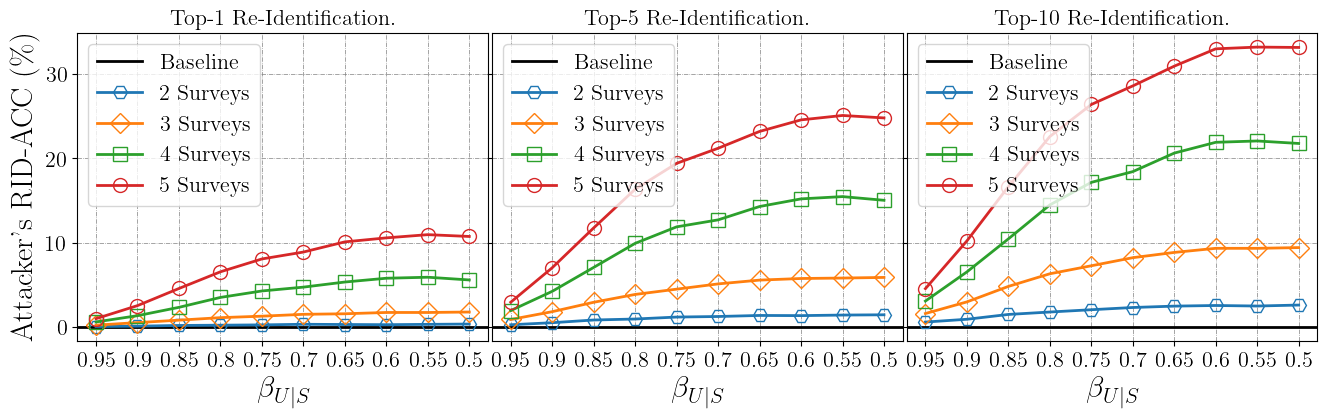

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
plt.subplots_adjust(wspace=0.01)

r = 0 #row

markers = ['H', 'D', 's', 'o'] 
lines = ['dashed', 'dotted', 'dashdot', (0, (1, 10))]

for top_k in [1, 5, 10]:
    ax[r].grid(color='grey', linestyle='dashdot', linewidth=0.5)
    ax[r].axhline(y= 100 * top_k/n, color='black', label='Baseline') #our baseline is a random top-k group
    
    #averaging results over nb_seed times
    for survey in range(2, nb_surveys + 1):
        
        lst_resul_atk = []
        for seed in range(nb_seed):
            lst_resul_atk.append(np.load(filename_grr+'Smp_Re_Ident_Attack_PIE_FK_Uniform_Seed_'+str(seed)+'.npy', allow_pickle=True).reshape(-1))
        
        error_rate_atk = 100 * np.array([np.mean([lst_resul_atk[idx][0][bayes_error][survey][top_k] for idx in range(nb_seed)]).astype(int) for bayes_error in lst_bayes_error])/n
        
        ax[r].plot(range(len(lst_bayes_error)), error_rate_atk, label=str(survey)+' Surveys', marker=markers[survey-2], markerfacecolor='none')

    ax[r].set_title('Top-'+ str(top_k)+ ' Re-Identification.')
    ax[r].set_xlabel(r'$\beta_{U|S}$', fontsize=22)
    ax[0].set_ylabel("Attacker's RID-ACC (\%)", fontsize=22)
    ax[r].set_xticks(range(len(lst_bayes_error)))
    ax[r].set_xticklabels(lst_bayes_error)
    ax[r].legend(loc='upper left')
    
    r += 1 
    
# plt.savefig(, dpi=500, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

## Reidentification Smp[GRR]: No Knowledge, Non-Uniform $\alpha$

In [ ]:
starttime = time.time()

ray.shutdown()

nb_cores = 12
ray.init(num_cpus=nb_cores, log_to_driver=False)

#run experiments 'nb_seed' times
# for seed in range(nb_seed):
print(my_seed)

np.random.seed(my_seed) 

# initialize dictionary to save number of people re-identified per epsilon
re_ident_attack_pie = {} 

# divide the dataset in nb_cores equal parts for later parallelization with Ray library
lst_idx_per_core = [list(_) for _ in np.array_split(df.index, nb_cores)]

# Randomly choose the number of attributes for each survey between min_att_per_survey and d
nb_att_survey = np.random.randint(min_att_per_survey, d, nb_surveys)

# Randomly select the indexes of the attributes for each survey
lst_att_survey = [np.random.choice(range(d), nb, replace=False) for nb in nb_att_survey]

#for each bayes error
for bayes_error in lst_bayes_error: 

    #Initializing a dictionary for each users' profile
    dic_id = {ID:{att:[] for att in attributes} for ID in range(n)}

    #Dictionary to save number of re-identified profiles per top-k group
    atk_top_k = {survey:{top_k:0 for top_k in range(1, 11)} for survey in range(1, nb_surveys + 1)}

    #For each survey
    for survey in range(1, nb_surveys + 1):  

        # we'll shuffle the users' order in the dataset
        df_shfl = df.sample(frac=1, random_state=my_seed+survey) #change seed with survey
        df_shfl.reset_index(drop=True, inplace=True)

        # we'll partitionate the users indexes to separate in nb_att_survey groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(df_shfl.index, nb_att_survey[survey - 1])]

        idx=0 #index for attribute
        for index_att in lst_att_survey[survey - 1]: #for each attribute of the survey

            att = attributes[index_att] #select attribute

            k = lst_k[index_att] #domain size of attribute

            lst_val = np.arange(k) #range of attribute

            #if no LDP is required
            p = 1 
            q = 0

            #calculate required epsilon to satisfy the bayes error 
            eps_l = get_eps_from_bayes_error(bayes_error, n_d, k)

            if eps_l > 0:
                # GRR parameters 
                p = np.exp(eps_l) / (np.exp(eps_l) + k - 1) 
                q = (1 - p) / (k - 1)

            # select users that report this attribute
            for ind, row in df_shfl.iloc[lst_index[idx]].iterrows():

                #confirm the user has never reported this attribute
                if len(dic_id[row['ID']][att]) == 0:
                    dic_id[row['ID']][att].append(GRR(row[att], lst_val, p, q))

            idx+=1

        #start attacking after 2 surveys
        if survey >= 2:

            result_parallel = [] #initialize list for parallelized results
            for lst_idx in lst_idx_per_core: 

                result_parallel.append(attack_re_identification.remote(lst_idx, dic_id, df)) #use remote function from Ray library

            parallel_atk = list(flatten(ray.get(result_parallel))) #take results with get function from Ray library

            lst_top_k = np.zeros(11) #initialize list of top-k re-identification attack

            for idx in range(len(parallel_atk)): #for each attacked profile

                for top_k in range(parallel_atk[idx], 11): #count as attack the top-k's group
                    lst_top_k[top_k] += 1

            atk_top_k[survey] = lst_top_k #store attack result for this number of surveys

    #for each epsilon we save the number of re-identified profiles for all top-k
    re_ident_attack_pie[bayes_error] = atk_top_k

# Saving to local file
np.save(filename_grr+'Smp_Re_Ident_Attack_PIE_FK_NonUniform_Seed_'+str(my_seed)+'.npy', re_ident_attack_pie) 
print('That took {} seconds'.format(time.time() - starttime))    

2025-03-06 11:28:18,891	INFO worker.py:1841 -- Started a local Ray instance.


0
That took 1815.4584789276123 seconds


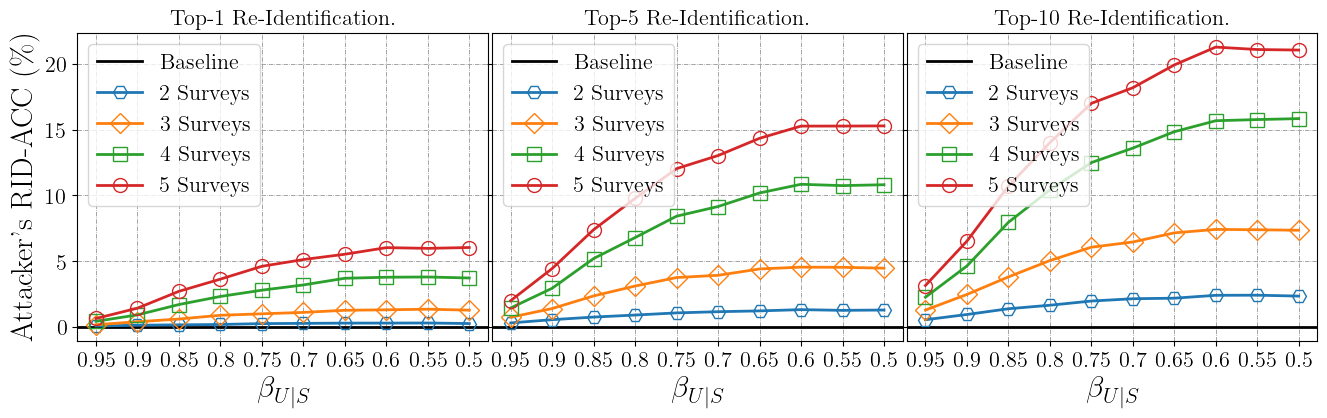

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
plt.subplots_adjust(wspace=0.01)

r = 0 #row

markers = ['H', 'D', 's', 'o'] 
lines = ['dashed', 'dotted', 'dashdot', (0, (1, 10))]

for top_k in [1, 5, 10]:
    ax[r].grid(color='grey', linestyle='dashdot', linewidth=0.5)
    ax[r].axhline(y= 100 * top_k/n, color='black', label='Baseline') #our baseline is a random top-k group
    
    #averaging results over nb_seed times
    for survey in range(2, nb_surveys + 1):
        
        lst_resul_atk = []
        for seed in range(nb_seed):
            lst_resul_atk.append(np.load(filename_grr+'Smp_Re_Ident_Attack_PIE_FK_NonUniform_Seed_'+str(seed)+'.npy', allow_pickle=True).reshape(-1))
        
        error_rate_atk = 100 * np.array([np.mean([lst_resul_atk[idx][0][bayes_error][survey][top_k] for idx in range(nb_seed)]).astype(int) for bayes_error in lst_bayes_error])/n
        
        ax[r].plot(range(len(lst_bayes_error)), error_rate_atk, label=str(survey)+' Surveys', marker=markers[survey-2], markerfacecolor='none')

    ax[r].set_title('Top-'+ str(top_k)+ ' Re-Identification.')
    ax[r].set_xlabel(r'$\beta_{U|S}$', fontsize=22)
    ax[0].set_ylabel("Attacker's RID-ACC (\%)", fontsize=22)
    ax[r].set_xticks(range(len(lst_bayes_error)))
    ax[r].set_xticklabels(lst_bayes_error)
    ax[r].legend(loc='upper left')
    
    r += 1 
    
# plt.savefig(, dpi=500, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

Please execute with more seeds for more stable plots and with the whole dataset for similar results to the paper